In [3]:
# enable intellisense. Type a variable, type a . (period) and then press TAB
%config IPCompleter.greedy=True

In [5]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myself\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [4]:
#-------------------------------------------------------------------------------
# Name:        module1
# Purpose:
#
# Author:      Chianson Siu, Wei Liao
#
# Created:     13/02/2019
#-------------------------------------------------------------------------------
import nltk
from nltk.corpus import stopwords
from collections import Counter
from scipy.stats.stats import pearsonr
import pandas as pd
import operator
import matplotlib.pyplot as plt
import numpy as np


def removeBodyXMLTags(df):
    '''
    This function removes all XML tags in the "Body" column of the pandas data
    frame, e.g, all <p> and </p> tags should be removed.
    @param df is a pandas dataframe with one column that refers to the
              body of the text named "Body"
    @return a pandas datafame    
    '''

    # For each post in column "Body" of the panda dataframe
    # Remove all XML tags and put the result back to the
    # corresponding cell
    for i in range(len(df.index)):
        # Obtain cell content to edit
        postBody = df.at[i, "Body"]

        # Remove XML flasg and put result back to corresponding column
        df.at[i, "Body"] = removeXMLTags(str(postBody))
    return df


def removeXMLTags(text):
    '''
    Given a string of content, remove all occurences of XML tags.
    (XML tags is anything that starts with '<' and ends with '>')

    @param text String. A string of text.

    @return a String with all occurences of XML tags removed
    '''

    textList = list(text)
    # Remove All the XML tags
    j = 0
    while j < len(textList):
        if textList[j] == "<":
            while textList[j] != ">":
                textList.pop(j)
            textList.pop(j)
        else:
            j += 1

    # Convert list back into string and return the result
    return ''.join(textList)



def wordToCount(text):
    '''
    Given a string of content, count the number of occurence of each word,
    then returns the result.
    
    @param text String. A string of text.

    @return a dictionary mapping word to word count
    '''
    wordDict = dict()
    textList = str(text).split(" ")
    for word in textList:
        key = word.lower()
        if key != " " and key != "":
            wordDict[key] = wordDict.get(key, 0) + 1
    return wordDict


def top10Words(wordDict):
    '''
    Given a dictionary that maps word to its occurence count, return a
    list of top 10 highest occuring words

    @param wordDict Dictionary. A dictionary that maps a word to the 
                    number of times that it occured in a text

    @return a list of top 10 highest occuring words
    '''
    
    # Create list of words to exclude from final list
    exclude = set(stopwords.words('english'))
    additionalStopWords = {"would", "want", "get", "make", "know",
                           "ask", "something", "may", "without", 
                           "stop", "one", "really", "someone",
                           "could", "need", "might", "me?", "i'm",
                           "even", "also", "way", "things", "tell",
                           "think", "feel", "say", "-", "like",
                           "need", "best", "talk", "deal"}
    
    # Add in additional words not contained in the NLK library
    exclude = exclude.union(additionalStopWords)
    
    result = list()
    # Sort dictionary into tuples according to value
    # Creates a list of tuples (word, count) sorted from highest count
    # to lowest count
    sorted_words = sorted(wordDict.items(), key=operator.itemgetter(1),
        reverse=True)

    # Take only the top 10 word part of the sorted_words
    # Exclude the common non-meaning words such as "the",
    # "of", "or"
    for i in range(100):
        # Make sure i is not over the range of sorted_words
        # and result has 10 words
        if i >= len(sorted_words) or len(result) == 10:
            break

        # Append words that are not in the exclude list
        if sorted_words[i][0] not in exclude:
            result.append(sorted_words[i][0])
    return result


def filter10User(users_df):
    '''
    Takes a user data frame. Filters out the first 10 users and store the
    results in a dictionary with key being the user ID and the value being
    the user's reputation score

    @param users_df Pandas datagrame. The datafram that contains information
                    on users.

    @return a dictionary of the first 10 users (key is user ID, value is
            reputation)
    ''' 
    result = dict()
    for i in range(10):
        # Make user dataframe has at least 10 entries
        if len(users_df.index) > 10:
            # Take the first 10 Id and Reputation out
            section = users_df.head(n=10)[["_Id", "_Reputation"]]
            # Store ID as key and Reputation as value
            result[section.iloc[i, 0]] = section.iloc[i, 1]
    return result


def numWords(text):
    '''
    Count the number of words there is in a block of string
    '''
    textList = text.split(" ")
    return len(textList)


def tagCount(text):
    textList = list(str(text))
    # take the words between the "<>"
    wordString = ""
    j = 0
    while j < len(textList):
        if textList[j] == "<":
            # pop out the first "<"
            textList.pop(j)
            while textList[j] != ">":
                wordString += textList.pop(j)
            textList.pop(j)
            wordString += " "
        else:
            j += 1

    tag_dict = wordToCount(wordString)
    return tag_dict

In [5]:
def q1(posts_df):
    '''
    Performs tasks necessary to solve research question 1
    '''

    # Create variables
    ans_tag = dict()
    ans_body = dict()
    ans_title = dict()
    ans_len = 0
    ans_count = 0
    
    noAns_tag = dict()
    noAns_body = dict()
    noAns_title = dict()
    noAns_len = 0
    noAns_count = 0

    # Fill in PostID, Length, AnswerCount of each row
    for i in range(len(posts_df.index)):
        body = posts_df.at[i, "Body"]

        # Obain each column info
        tags = tagCount(posts_df.at[i, "Tags"])
        top10Body = wordToCount(body)
        length = numWords(str(body))
        title = wordToCount(posts_df.at[i, "Title"])

        # Add a new row in the ans or no_ans dataframe with the correct values
        if pd.isnull(posts_df.loc[i, "AcceptedAnswerId"]):
            # There is no accepted answer
            noAns_tag = Counter(noAns_tag) + Counter(tags)
            noAns_body = Counter(noAns_body) + Counter(top10Body)
            noAns_title = Counter(noAns_title) + Counter(title)
            noAns_len += length
            noAns_count += 1
        else:
            ans_tag = Counter(ans_tag) + Counter(tags)
            ans_body = Counter(ans_body) + Counter(top10Body)
            ans_title = Counter(ans_title) + Counter(title)
            ans_len += length
            ans_count += 1
    
    #results = [[top10Words(noAns_tag), top10Words(noAns_body), top10words(noAns_title), float(noAns_len/noAns_count)], 
    #            [top10Words(noAns_tag), top10Words(noAns_body), top10words(noAns_title), float(noAns_len/noAns_count)]]
    
    results = dict()
    
    results["noAns_tag"] = top10Words(noAns_tag)
    results["noAns_body"] = top10Words(noAns_body)
    results["noAns_title"] = top10Words(noAns_title)
    results["noAns_avg_len"] = int((noAns_len/noAns_count))

    
    results["ans_tag"] = top10Words(ans_tag)
    results["ans_body"] = top10Words(ans_body)
    results["ans_title"] = top10Words(ans_title)
    results["ans_avg_len"] = int((ans_len/ans_count))
    
    return results

In [6]:
def q2(posts_df, users_df):
    '''
    Performs tasks necessary to solve research question 2
    '''
    q2_df = pd.DataFrame(columns=("UserID", "Reputation", "AnswerCount", 
        "AverageBodyLength"))

    # Get UserID and Reputation first
    q2_df.loc[ : , "UserID"] = users_df.loc[ : , "_Id"]
    q2_df.loc[ : , "Reputation"] = users_df.loc[ : , "_Reputation"]

    # id to length and count dictionary
    id_lenCount = dict()

    # Find which posts are answers
    ans_set = set()
    for i in range(len(posts_df.index)):
        # this post is an answer
        if int(posts_df.at[i, "PostTypeId"]) == 2:
            ans_set.add(posts_df.at[i, "Id"])

    # Fill in answer count and accumulate body length for now
    for i in range(len(posts_df.index)):
        userID = posts_df.at[i, "OwnerUserId"]
        # add only if userID exist and if the post is an answer
        if userID in q2_df.loc[ : , "UserID"] and posts_df.at[i, "Id"] in ans_set:
            if userID not in id_lenCount.keys():
                # list first element is count, second is accumulated body len
                id_lenCount[userID] = list()
                id_lenCount[userID].append(0)
                id_lenCount[userID].append(numWords(str(posts_df.at[i, "Body"])))
            else:
                id_lenCount[userID][0] += 1
                id_lenCount[userID][1] += numWords(str(posts_df.at[i, "Body"]))

    # Now fill average length and answer count back into the main table
    for i in range(len(q2_df.index)):
        userID = q2_df.at[i, "UserID"]
        if userID in id_lenCount.keys():
            answerCount = id_lenCount[userID][0]
            q2_df.at[i, "AnswerCount"] = answerCount
            if answerCount != 0: # int conversion rounds down because only want whole word
                q2_df.at[i, "AverageBodyLength"] = int(id_lenCount[userID][1]/answerCount)

    q2_df = q2_df.dropna()
    
    # q2_df.to_excel("Q2_Result.xlsx")
    return q2_df

In [7]:
def q3(users_df):
    '''
    Performs tasks necessary to solve research question 3
    '''
    q3_df = pd.DataFrame(columns=("UserID", "Reputation", "UpVotes",
        "DownVotes"))

    # extract the userID, reputation, upvotes, and downvotes
    q3_df.loc[ : , "UserID"] = users_df.loc[ : , "_Id"]
    q3_df.loc[ : , "Reputation"] = users_df.loc[ : , "_Reputation"]
    q3_df.loc[ : , "UpVotes"] = users_df.loc[ : , "_UpVotes"]
    q3_df.loc[ : , "DownVotes"] = users_df.loc[ : , "_DownVotes"]
    
    
    # remove rows with any zeros
    q3_df = q3_df[(q3_df != 0).all(1)]
    
    q3_df["RatioUpToDown"] = q3_df["UpVotes"] / q3_df["DownVotes"]
    #print(q3_df)
    #q3_df.to_excel("Q3_Result.xlsx")
    return q3_df

In [8]:
# read in the CSV file to pandas dataframe. The CSV file must be coded as
# UTF-8.
posts_df = pd.read_csv("Posts2018.csv")
posts_df = removeBodyXMLTags(posts_df)

In [9]:
users_df = pd.read_csv("Users.csv")

In [10]:
# Research Question 1 Analysis DONE!
q1_result_dict = q1(posts_df)
q1_result_dict

{'noAns_tag': ['conversations',
  'relationships',
  'united-states',
  'friends',
  'work-environment',
  'conflict-aversion',
  'awkward-situations',
  'difficult-people',
  'politeness',
  'family'],
 'noAns_body': ['people', 'time', 'person', 'good', 'try'],
 'noAns_title': ['nan',
  'friend',
  'people',
  'politely',
  'communicate',
  'respond',
  'friends',
  'asking',
  'handle',
  'talking'],
 'noAns_avg_len': 289,
 'ans_tag': ['conversations',
  'friends',
  'relationships',
  'conflict-aversion',
  'united-states',
  'awkward-situations',
  'politeness',
  'work-environment',
  'family',
  'conflicts'],
 'ans_body': ['time', 'people', 'friends', 'friend', 'go', 'good'],
 'ans_title': ['friend',
  'politely',
  'convince',
  'people',
  'girlfriend',
  'friends',
  'partner',
  'handle',
  'communicate',
  'talking'],
 'ans_avg_len': 329}

In [15]:
# Research Question 2 Analysis DONE! (accepted answer post only?)
q2_result_df = q2(posts_df, users_df)
q2_result_df

,UserID,Reputation,AnswerCount,AverageBodyLength
18,18,5603,3,380
29,29,6652,14,229
36,36,12493,8,607
57,59,48108,43,285
59,61,28799,17,406
63,65,2326,3,245
72,75,1941,3,495
75,78,196,1,289
85,88,2296,3,447
94,98,2819,3,166


In [12]:
# Research Question 3 Analysis
q3_result_df = q3(users_df)
q3_result_df

,UserID,Reputation,UpVotes,DownVotes,RatioUpToDown
0,-1,1,2231,4082,0.546546
3,3,90,10,81,0.123457
7,7,96,11,8,1.375000
10,10,434,26,3,8.666667
12,12,872,8,1,8.000000
13,13,446,58,5,11.600000
16,16,942,99,165,0.600000
17,17,2566,25,5,5.000000
18,18,5603,72,52,1.384615
19,19,1144,19,40,0.475000


In [13]:
'''
original main method
def main():
    # read in the CSV file to pandas dataframe. The CSV file must be coded as
    # UTF-8.
    posts_df = pd.read_csv("Posts2018.csv")
    posts_df = removeBodyXMLTags(posts_df)

    # Research Question 1 Analysis DONE! (fix stopword list)
    q1(posts_df)

    users_df = pd.read_csv("Users.csv")

    # Research Question 2 Analysis DONE! (accepted answer post only?)
    q2(posts_df, users_df)

    # Research Question 3 Analysis
    q3(users_df)

  #  df = pd.read_csv("Comments.csv")
   # print(df.loc[0, :])


# If this file is run as a Python script (such as by typing
# "python tests.py" at the command shell), then run the following:
if __name__ == "__main__":
    main()
'''

'\ndef main():\n    # read in the CSV file to pandas dataframe. The CSV file must be coded as\n    # UTF-8.\n    posts_df = pd.read_csv("Posts2018.csv")\n    posts_df = removeBodyXMLTags(posts_df)\n\n    # Research Question 1 Analysis DONE! (fix stopword list)\n    q1(posts_df)\n\n    users_df = pd.read_csv("Users.csv")\n\n    # Research Question 2 Analysis DONE! (accepted answer post only?)\n    q2(posts_df, users_df)\n\n    # Research Question 3 Analysis\n    q3(users_df)\n\n  #  df = pd.read_csv("Comments.csv")\n   # print(df.loc[0, :])\n\n\n# If this file is run as a Python script (such as by typing\n# "python tests.py" at the command shell), then run the following:\nif __name__ == "__main__":\n    main()\n'

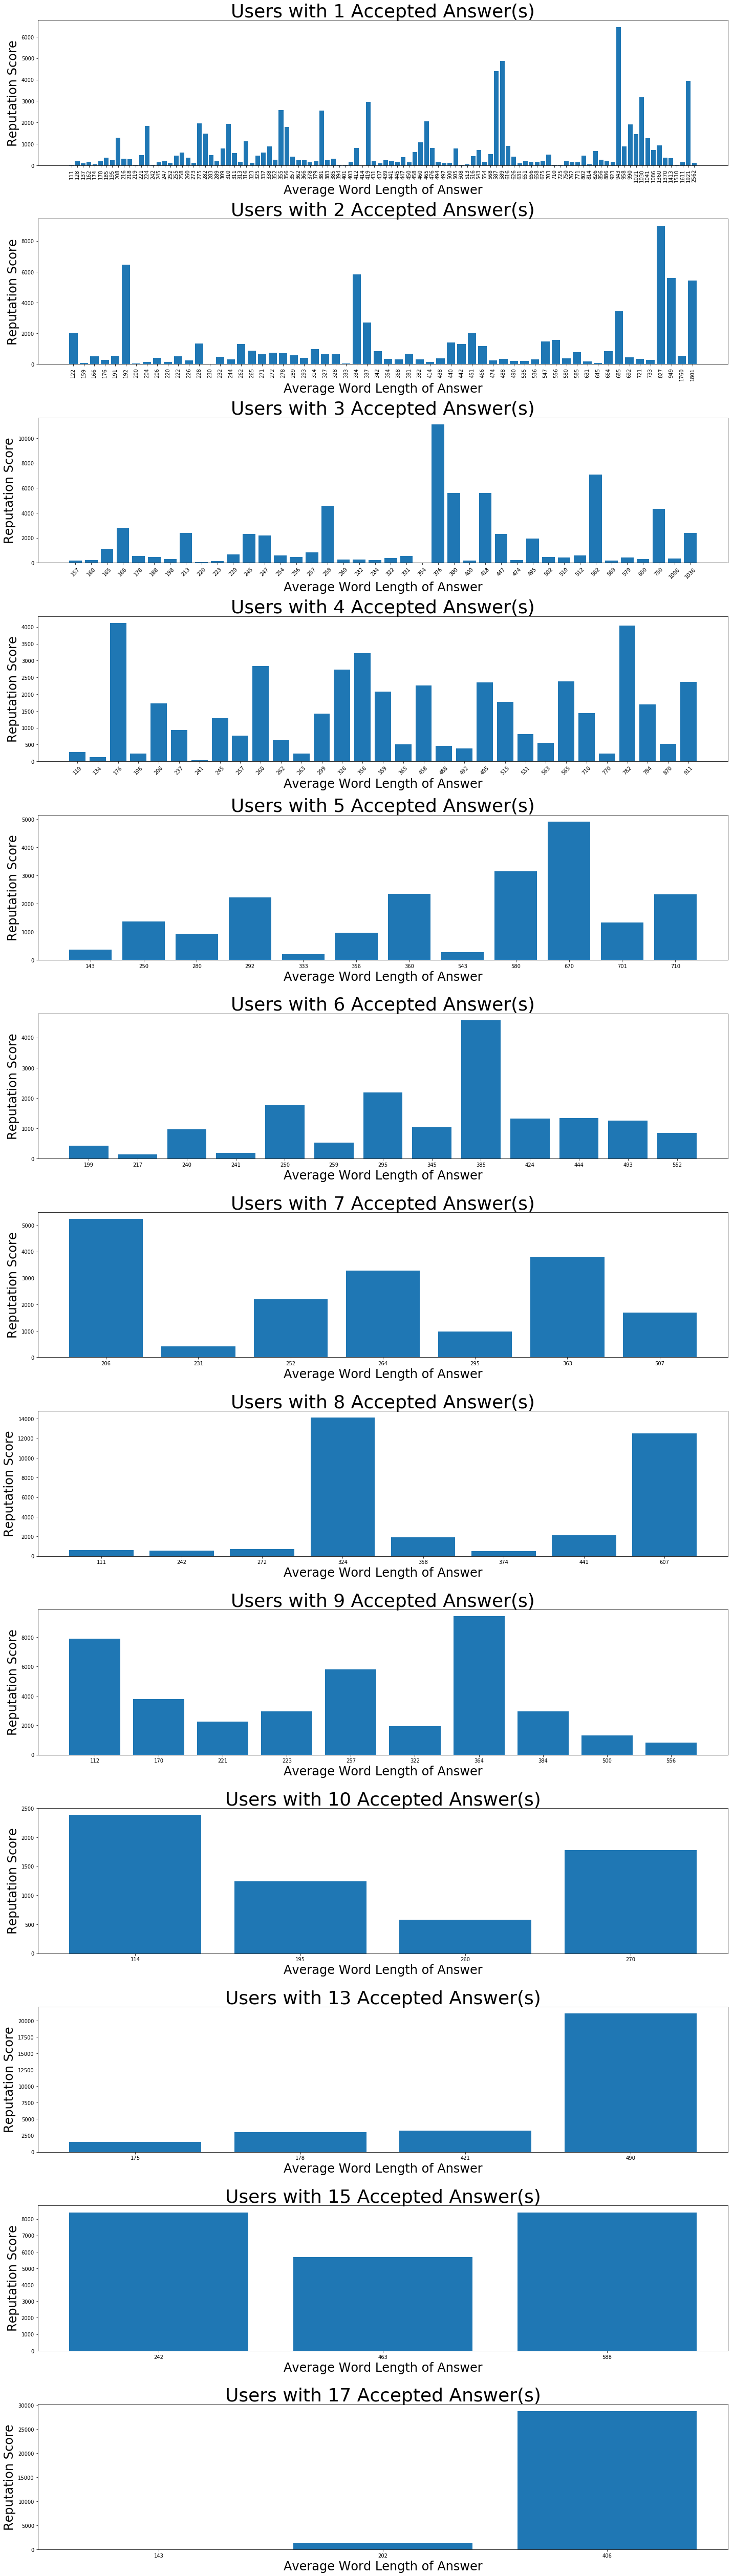

In [17]:
# get all variations of answer counts
# this represents number of questions answered
allAnswerCounts = set(q2_result_df["AnswerCount"])

# create matplot figure with initial size 80 x 5
# width is much greater than height because 
# each bar chart will have many categories
height = 5
fig = plt.figure(figsize = (8.5, height))

# counter for position the graph
index = 1
for answerCount in allAnswerCounts:
    # boolean filter array for the answerCount
    ansFilter = q2_result_df['AnswerCount'] == answerCount

    # user filter results to make a bar chart
    eachAnswerCount = q2_result_df[ansFilter]

    if(len(eachAnswerCount.index) > 2):
        #sort the new table by AverageBodyLength ascending
        eachAnswerCount = eachAnswerCount.sort_values(by=['AverageBodyLength'])

        # convert panda to array because matplot expects an array
        # arrayToGraph = eachAnswerCount.values

        # x-axis = avg length (low to high) 
        # convert to string to allow matplot to recognize it as category
        xAxis = eachAnswerCount['AverageBodyLength'].astype(str).values
        
        # y-axis = reputation points
        values = eachAnswerCount['Reputation'].values
        
        # increment default defaultHeight for next interation
        height += 5
        
        # increase figure height to accomodate new graph
        fig.set_size_inches(20, height)
        
        # add new blank subplot to the figure
        #13 x 1 because there are 13 plots
        ax = fig.add_subplot(13, 1, index)
        
        # add axes (the bars) to the subplot
        ax.bar(xAxis, values)
        
        # get x axis labels
        xTicks = ax.get_xticklabels()
        
       
        # rotate the x-axis tick values
        for tick in xTicks:
            if(len(xTicks) > 40):
                tick.set_rotation(90)
            elif(len(xTicks) > 15):
                tick.set_rotation(45)
        ax.set_xlabel("Average Word Length of Answer", fontsize = 24)
        ax.set_ylabel("Reputation Score", fontsize = 24)
        ax.set_title("Users with " + str(answerCount) + " Accepted Answer(s)", fontsize = 36)
        
        
        index += 1 #increment position for next graph

fig.tight_layout()
fig.savefig("figures/q2_bar_charts.png")
fig.savefig("figures/q2_bar_charts_.pdf")

In [ ]:
q3_result_df


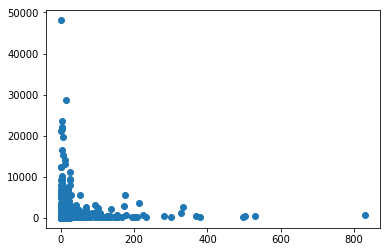

In [18]:
less200Ratio = q3_result_df["RatioUpToDown"] <= 200
less200Table = q3_result_df[less200Ratio]

fig2 = plt.figure()

scatterXall = q3_result_df["RatioUpToDown"].values
scatterYall = q3_result_df["Reputation"].values

plt.scatter(scatterXall, scatterYall)


In [22]:
less200Ratio = q3_result_df["RatioUpToDown"] <= 200
less200Table = q3_result_df[less200Ratio]

less200Table

,UserID,Reputation,UpVotes,DownVotes,RatioUpToDown
0,-1,1,2231,4082,0.546546
3,3,90,10,81,0.123457
7,7,96,11,8,1.375000
10,10,434,26,3,8.666667
12,12,872,8,1,8.000000
13,13,446,58,5,11.600000
16,16,942,99,165,0.600000
17,17,2566,25,5,5.000000
18,18,5603,72,52,1.384615
19,19,1144,19,40,0.475000


In [19]:
pearsonr(scatterX, scatterY)

(-0.04303291001191956, 0.18790154783237578)